In [42]:
import torch
import sys
sys.path.insert(0, "../CCGMultitask")
from model import MultiTaskModel
import pickle

import seaborn
import numpy
import pandas as pd

In [31]:
model_fn = "../CCGMultitask/models/augment/augment_.50_{}_sgd_continue"

def load_model(model_fn, cuda=False):
    with open(model_fn + ".w2idx", "rb") as w2idx_f:
        w2idx = pickle.load(w2idx_f)
 
    with open(model_fn + ".c2idx", "rb") as c2idx_f:
        c2idx = pickle.load(c2idx_f)
  
    model = MultiTaskModel(len(w2idx.keys()), 650, 650,
                             [len(w2idx.keys()), len(c2idx.keys())], 2,)
    model.load_state_dict(torch.load(model_fn + ".pt",
                                       map_location = torch.device("cuda" if cuda
                                                               else "cpu")))
    if cuda:
        model = model.cuda()
    else:
        model = model.cpu()
  
    model.eval()
    return model, w2idx, c2idx

models = []
for i in range(5):
    model, _, _= load_model(model_fn.format(i))
    models.append(model)


In [49]:
def extract_var_by_unit(model):
    weights = []
    for decoder in model.decoders:
        weight = decoder.linear.weight
        impact_per_hu = weight.var(dim=0)
        weights.append(impact_per_hu.detach())
    return {"lm":weights[0], "ccg":weights[1]}

weightss = []

y = {}
for i, model in enumerate(models):
    x = extract_var_by_unit(model)
    y["lm"] = y.get("lm", []) + x["lm"].tolist()
    
    y["ccg"] = y.get("ccg", []) + x["ccg"].tolist()
    y["model"] = y.get("model", []) + [i for k in range(x["ccg"].size()[0])] 
    
    weightss.append(x)
    
df = pd.DataFrame(data=y)
df

df.to_csv("unit_impact.csv")

-0.22679402436441556
-0.21175885592355867
-0.2289035130560773
-0.28839587063965194
-0.2686949365636186


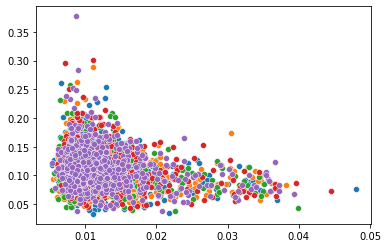

In [41]:
for i in range(5):
    seaborn.scatterplot(x=weightss[i][0], y=weightss[i][1])
    print(numpy.corrcoef(x=weightss[i][0], y=weightss[i][1])[0][1])

<AxesSubplot:>

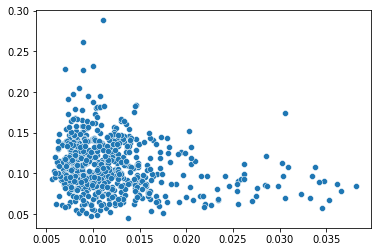

In [34]:
seaborn.scatterplot(x=weightss[1][0], y=weightss[1][1])